<h1>Brandon Kohrt</h1>

Gymnasium Final Project - Lunar Landing

The goal of this project is to create and train an AI to play the LunarLanding Game. This project utilzes Gymnasium. Gymnasium is a project that provides an API for single agent reinforcement learning environments, with implementations of common environments including Lunar Landing. Lunar Landing is a simple game where the player is trying to land a spacecraft on a certain spot without crashing. The provided environment allows for the ability to train AI agents to adequately naviagte the spaceship to the ground. I start by creating a qlearning agent, display the results and then create a more complex agent that utilizes deep qlearning. Deep qlearning combines neural netowrks and qlearning. This took additional research to implement and I have provided sevral resources at the end of the document that I refrenced.

This is how the environment is set up (taken directly from the [website](https://gymnasium.farama.org/environments/box2d/lunar_lander/)):

<h2>Action Space</h2>

There are four discrete actions available:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine


<h2>Observation Space</h2>

The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.


<h2>Rewards</h2>


After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

is increased/decreased the closer/further the lander is to the landing pad.

is increased/decreased the slower/faster the lander is moving.

is decreased the more the lander is tilted (angle not horizontal).

is increased by 10 points for each leg that is in contact with the ground.

is decreased by 0.03 points each frame a side engine is firing.

is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

The next cell runs the game with an agent that takes entirely random moves as a demonstration. We can see that the rocket kind of goes all over the place as we expect.

In [41]:
import gymnasium as gym
env = gym.make("LunarLander-v3", render_mode="human")
observation, info = env.reset()
rewards = 0
steps = 0
episode_over = False
while not episode_over:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    rewards+= reward
    steps += 1
    episode_over = terminated or truncated
print(f"Rewards: {rewards} Steps: {steps}")
env.close() 

Rewards: -225.8902574856077 Steps: 88


As we can see, randomly selecting actions is not a great way to go, so let's start by creating an extremely simple agent and see what happens. The first agent we are going to use uses the game state, accessed through the observation, to add weight to different actions - essentially calulating qvalues based on the current game state and the results of a successor gamestate. This is very simple qlearning and is effective in some simple tasks and games such as pacman.

In [45]:
import numpy as np
N_ACTION = 4    #action space
N_STATE_DIM = 8 #observation space
W = np.zeros((N_ACTION, N_STATE_DIM)) #weights
EPSILON = 0.1
def agent(observation): #agent chooses a random actions ~10% of the time to explore, uses the policy action the rest of the time and updates 
    if np.random.random() < EPSILON:
        return env.action_space.sample()
    else:
        state = np.array(observation).reshape(-1)
        qvals = W @ state
        return np.argmax(qvals)


In [46]:
env = gym.make("LunarLander-v3", render_mode="human")
N_EPISODE = 20
EPSILON = 0.1 
DISCOUNT = 1.0
learning_rate = 0.001
episode_rewards = np.zeros(N_EPISODE)
for ep in range(N_EPISODE): #run the game
    observation, info = env.reset()
    while True:
        state = np.array(observation).reshape(-1)
        action = agent(observation)
        new_observation, reward, terminated, truncated, info = env.step(action) #take an action

        new_state = np.array(new_observation).reshape(-1)
        new_action = agent(new_observation)
        target = reward + DISCOUNT*np.dot(W[new_action, :], new_state) #needed to calculate loss

        W[action, :] += learning_rate * (target - np.dot(W[action, :], state)) * state #adjust weights
        episode_rewards[ep] = reward
        if terminated or truncated:
            break
        observation = new_observation
env.close()

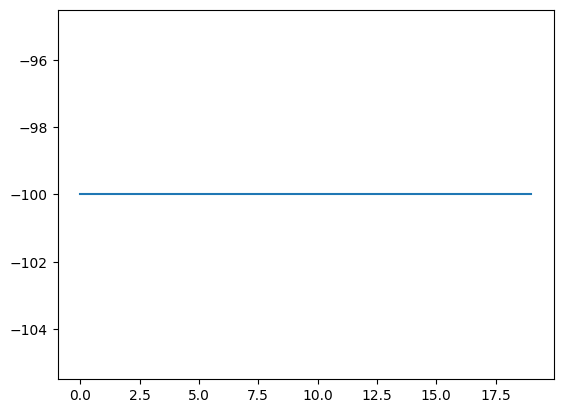

In [47]:
import matplotlib.pyplot as plt
episode_rewards
plt.plot(episode_rewards)

As we can see from the above graph, the simple Agent we used did not do a terrible job, but always crashed into the ground resulting in a score of -100 being given to the episode by the environment. This could be for many reasons with the two most likely being not enough iterations for the agent to properly olearn or the agent is too simple and is not suitable for this problem. Let's increase the number of iterations to address this issue and see the results.

In [48]:
env = gym.make("LunarLander-v3", render_mode="human")
N_EPISODE = 200
EPSILON = 0.1 
DISCOUNT = 1.0
learning_rate = 0.001
episode_rewards = np.zeros(N_EPISODE)
for ep in range(N_EPISODE): #run the game
    observation, info = env.reset()
    while True:
        state = np.array(observation).reshape(-1)
        action = agent(observation)
        new_observation, reward, terminated, truncated, info = env.step(action) #take an action

        new_state = np.array(new_observation).reshape(-1)
        new_action = agent(new_observation)
        target = reward + DISCOUNT*np.dot(W[new_action, :], new_state) #needed to calculate loss

        W[action, :] += learning_rate * (target - np.dot(W[action, :], state)) * state #adjust weights
        episode_rewards[ep] = reward
        if terminated or truncated:
            break
        observation = new_observation
env.close()

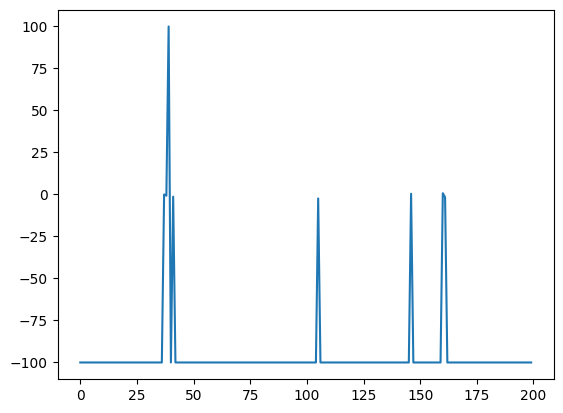

In [49]:
import matplotlib.pyplot as plt
episode_rewards
plt.plot(episode_rewards)

From the graph above we can see some improvement, but these results definitely point to the idea that we need a more robust algorithm that can get ot the point of making better decisons more quickly and accuately. This is where Deep q-learning comes into play. This stragey combines neural networks and qlearning to train the agent. This is a good model to use for many reasons. First, more complex qlearning problems like this solving in a tabular way as above can create a lot of overhead due to the amount of iterations and the length of the table, so it is often impractical. To solve this issue, we use the nueral network which predicts the qvalue of a given state and action and makes decisons based on this calculation. This way everyting does not need to be stored in a table and provides an ability to make the agent more complex. Below is a realtively simple implemntation of a neural netwrok.

In [7]:
import tensorflow as tf
def simple_nn():
    x = tf.keras.Input(shape = (8, ))
    h1 = tf.keras.layers.Dense(64, activation = 'relu')(x)
    h2 = tf.keras.layers.Dense(64, activation = 'relu')(h1)
    out = tf.keras.layers.Dense(4)(h2)
    return tf.keras.Model(inputs = x, outputs = out)

Each layer performs calculations to help the model come to a decision by extracting different features from the data it is given, and then passes that information down to the next layer, muchg like actual neurons in the brain. The more complex the model becomes though, the less interprable it is as well. This is not inherently bad, but often if you can create a more ximple model to solve a problem that is more advantageous! Below we can see a summary of this nerual network as well.

In [8]:
model = simple_nn()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,996 (19.52 KB)

 Trainable params: 4,996 (19.52 KB)

 Non-trainable params: 0 (0.00 B)

The next cell will demonstrate what the neural network is doing when we give it an observation. Essentially, it is trying to predict the qvalue of a certain state and action. So, if we pick a random choice we can see what the model will spit out. As we can see it produces a value for each of the available actions from the current state, so the best action as of now would be the action that gave us the highest value from this list.

In [9]:
state = env.observation_space.sample()   # we sample one observation
x = model(tf.convert_to_tensor([state]))  # run the model on it,
print(x)

tf.Tensor([[ 0.7962872   1.1358284  -0.29560998 -0.7244035 ]], shape=(1, 4), dtype=float32)


Next, we need to implement gradient descent. Gradient descent is a fundamental algorithm for training various machine learning models, including linear regression, logistic regression, and neural networks. Gradient descent aims to find the parameter values, in this case weights in the neural network, that minimize a cost function, which measures how well the model is performing. In this case we calulate the difference between a target reward and how far our reward from choosing an action is. We want to minimnze our loss, so we take the action that gets us a close to that reward as possible and update this on each iteration. Below is the implementation for one iteration.

In [10]:
observation, info = env.reset()
with tf.GradientTape() as t:
    action_probs = model(tf.convert_to_tensor([observation]))
    new_observation, reward, terminated, truncated, info = env.step(action)

    new_action_probs = model(tf.convert_to_tensor([new_observation]))
    target = reward + DISCOUNT * tf.math.reduce_max(new_action_probs)
    loss = (target - tf.math.reduce_max(action_probs))**2
    grad = t.gradient(loss, model.trainable_variables)

for var, g in zip(model.trainable_variables, grad):
    print(f'{var.name}, shape: {g.shape}')

kernel, shape: (8, 64)
bias, shape: (64,)
kernel, shape: (64, 64)
bias, shape: (64,)
kernel, shape: (64, 4)
bias, shape: (4,)


Fortunately, this is done using an optimizer which automatically finds the best combinations to use and applies it to the neural network as shwon below.

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3) # Instantiate an optimizer
# Run one step of gradient descent by updating the value of the variables to minimize the loss.
optimizer.apply_gradients(zip(grad, model.trainable_weights))

<Variable path=SGD/iteration, shape=(), dtype=int64, value=1>

By combining each of the additonal steps we can create a relatively simple deep q-learning network as shown belwo

In [ ]:
env = gym.make("LunarLander-v3", render_mode="human")
N_EPISODE = 100
EPSILON = 0.1
DISCOUNT_FACTOR = 1.0
LR = 1e-3
optimizer = tf.keras.optimizers.SGD(learning_rate = LR)
episode_rewards = np.zeros(N_EPISODE)
for ep in range(N_EPISODE): #go through many iterations
    observation, info = env.reset()
    while True:
        with tf.GradientTape() as t:
            action_probs = model(tf.convert_to_tensor([observation])) #model the available actions from the state
            action = np.argmax(action_probs.numpy()[0]) #choose an action
            if np.random.random() < EPSILON: #explore
                action = env.action_space.sample()
            new_observation, reward, terminated, truncated, info = env.step(action)

            new_action_probs = model(tf.convert_to_tensor([new_observation])) #model the next observation
            target = reward+DISCOUNT_FACTOR*tf.math.reduce_max(new_action_probs) #calculate target

            loss = (target-action_probs.numpy()[0][action])**2 #calculate loss
            grad = t.gradient(loss, model.trainable_variables) #calculate gradient

            optimizer.apply_gradients(zip(grad, model.trainable_weights)) #optimize the neural network based on loss and gradeint
            episode_rewards[ep] += reward
            if terminated or truncated:
                break
            observation = new_observation
env.close()


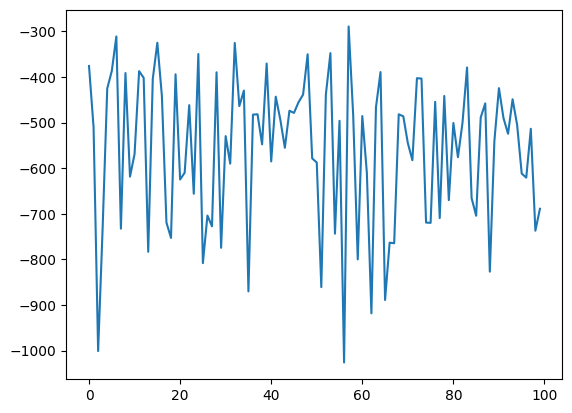

In [13]:
plt.plot(episode_rewards)

This may look like bad results, however a caveat of neural networks is that they need a TON of iterations to become an adequate agent, and we only did 100 episodes to train on, so let us increase this and see what happens!

In [ ]:
env = gym.make("LunarLander-v3", render_mode="human")
N_EPISODE = 500 #5 times more episodes to go through, everything else is the same
EPSILON = 0.1
DISCOUNT_FACTOR = 1.0
LR = 1e-3
optimizer = tf.keras.optimizers.SGD(learning_rate = LR)
episode_rewards = np.zeros(N_EPISODE)
for ep in range(N_EPISODE):
    observation, info = env.reset()
    while True:
        with tf.GradientTape() as t:
            action_probs = model(tf.convert_to_tensor([observation]))
            action = np.argmax(action_probs.numpy()[0])
            if np.random.random() < EPSILON:
                action = env.action_space.sample()
            new_observation, reward, terminated, truncated, info = env.step(action)

            new_action_probs = model(tf.convert_to_tensor([new_observation]))
            target = reward+DISCOUNT_FACTOR*tf.math.reduce_max(new_action_probs)

            loss = (target-action_probs.numpy()[0][action])**2
            grad = t.gradient(loss, model.trainable_variables)

            optimizer.apply_gradients(zip(grad, model.trainable_weights))
            episode_rewards[ep] += reward
            if terminated or truncated:
                break
            observation = new_observation
env.close()

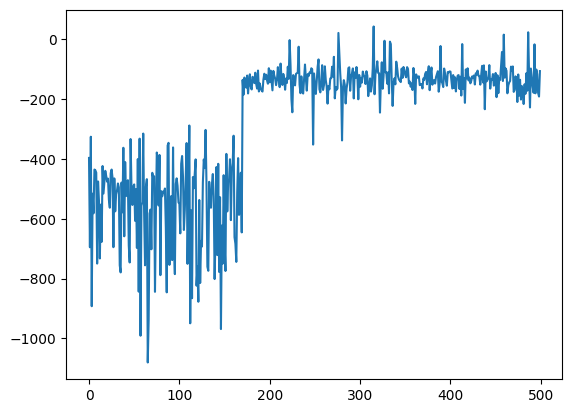

In [21]:
plt.plot(episode_rewards)

Much better! Interestingly, at around 180 episodes there is a large jump in score. I beleive this is due to the fact that by defualt the action is to activate the right engine and zoom to the left. Once enough iterastions have passed to change this autmatic behavior, we get much better scores. But, as alluded to above, this is only specualtion as it is impossible to actually see what the agent is doing to arrive at these outputs. Although these scores aren't perfect, there is a marked improvement from the previous model. 

In summary, the more complex deep learning model more consistently got higher scores as compared to the first  basic q-learning agent. However, it is important to note that we did up to 500 episodes for the more complex model, but not for the simpler one. This was due to the preliminary results of the first two grpahs provided above. The deep network is still realtively simple espeically compared to other models that have successfully solved this problem.

To start with improvements, typically these models take 1000 or more iterations to get more accurate results which I would rather not run. Also, according to other resources it is likely this model will not have a marked improvment after 1000 episodes, and again making the model more complex will help improve it significantly. This can be done in several ways. First, many of these models employ batch processing. Batch processing is a technique where the training data is divided into smaller "batches" and given to the neural network in separate chunks, rather than all at once. This allows the network to make more efficient use of its resources and can significantly reduce the time it takes to train. This would allow more iterations and thus more updates leading to a stronger model. Additoanlly, many models start with a high EPSILON or 100% exploration, and then decrease this on each iteration. This strikes a nice balance between exploration vs. exploitation, with the idea being by the time the EPSILON becomes 0 or less than 0, the model is hopefully close to optimal. 

This project allowed me to learn much more about q-learning and neural netwroks and learn about a way to combine these two models into a deep q-learning model. Although there was an attempt I made to make the model more complex to try and get a higher score, I was finding this very complicated and was not able to get a better model working correctly. One of the problmes I ran into was the model choosing to do nothing everytime. From things I have seen online this is because the model is deciding that scoring -100, i.e crashing, is better than scoring -400. This was fixed by adding in the randomness of exploring. Orginally, my EPSILON was 5, for randomness about 5% of the time, but this was taking too long, and increasing this to 10 solved this issue.


https://gymnasium.farama.org/introduction/train_agent/

https://deeplearning.neuromatch.io/projects/ReinforcementLearning/lunar_lander.html

https://github.com/tensorflow/agents/blob/master/tf_agents/agents/dqn/dqn_agent.py

https://statwizard.substack.com/p/reinforcement-learning-part-7-solving

https://machinelearningmastery.com/improve-deep-learning-performance/

https://www.geeksforgeeks.org/optimization-rule-in-deep-neural-networks/

https://github.com/openai/

https://github.com/Farama-Foundation/Gymnasium

https://www.youtube.com/playlist?list=PL58zEckBH8fCt_lYkmayZoR9XfDCW9hte 